# ResNets

ResNet is a type of neural network architecture where the outputs of a previous layer are fed as input to a subsequent layer (e.g. skip connections).

![resnet](media/resnet.png)

# Neural Ordinary Differential Equations (Chen et al.)
Chen et al. recognized that ResNets were very similar to Euler's method, a simple first-order method to approximate a differentiable function typically learned in undergraduate calculus. Euler's method for approximating a function is as follows

$$y_{i+1} = y_i + h \cdot f(x)$$

where $h$ is called the step size. 

Chen et al. showed that instead of modeling $F: x \rightarrow y$ as a neural network which has a discrete number of hidden layers, we can reformulate the problem in a continuous setting. Namely, let us call $z(t)$ the **hidden state** which depends on $t$ ($t$ can but does not have to represent time). The final hidden state at some time $t_1$ after $t_0$ will be $z(t_1) = y$. 

The derivative of $z(t)$ with respect to $t$ is modeled as a neural network $f$ which receives $z(t)$ and $t$ as input and is parameterized by parameters $\theta$. Notice that the values of the initial time $t_0$ and final time $t_1$ are not well-defined. Like the parameters of the neural network $\theta$, $t_0$ and $t_1$ are free parameters and are likewise optimized through gradient descent with respect to the loss $\mathcal{L}$.

In summary, we are learning a function $f(t, z(t), \theta)$ such that

$$f(t, z(t), \theta) = \frac{d z(t)}{d t}$$
$$z(t_0) = x$$
$$z(t_1) = y$$

Our prediction $\hat{y}$ is thus

$$\widehat{y} = z(t_1) = \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big)$$

where $ODESolve$ is any numerical ODE solver (e.g. Runge-Kutta) which solves for the hidden state at $t_1$, $z(t_1)$. To optimize, the free parameters $t_0$, $t_1$, and $\theta$, the adjoint sensitivity method as described by Chen et al. is first used to find the gradients $\frac{d \mathcal{L}}{d z(t)}$ and $\frac{d \mathcal{L}}{d \theta}$ where $\mathcal{L}$ is a scalar loss (e.g. squared loss) defined as 

$$
L(z(t_1)) = L \Big( \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big)
$$

The free parameters are then optimized using gradient descent. 

## Adjoint Sensitivity Method

As alluded to previously, the **adjoint method** is a way to perfrom the backward pass for neural ODEs and compute the gradients with respect to the free parameters. Assume as before that $z(t_1)$ is the output of our model. The free parameters in this case are

* $t_0$: the initial time
* $t_1$: the final time
* $z(t_0)$: initial state
* $\theta$: parameters of $f$

We first define the **adjoint** $a(t)$ as the gradient of the loss $\mathcal{L}$ with respect to the state $z(t_i)$ at some arbitrary time.

$$
a(t_i) = -\frac{\partial L}{\partial z(t_i)}
$$

Using the chain rule, computing the gradient $\frac{\partial L}{t_1}$ is just

$$
\frac{\partial L}{\partial t_1} = - a(t_1) \frac{\partial f(z(t_1), t_1, \theta)}{\partial t}
$$

The computation for the other gradients is not as trivial. First, using the chain rule we can rewrite the derivative of the adjoint with respect to time as

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z}
$$

To obtain $\frac{\partial L}{\partial z(t_0)}$, we can then solve this differential equation with a numerical solver.

$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt
$$

Note that the initial value of this differential equation $\frac{\partial L}{\partial z(t_1)}$ can be directly computed with normal backpropagation. We can likewise solve a two more backwards ODE to find the gradients for $\theta$ and $t_0$.

$$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt
$$

$$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt
$$

![adjoint_method](media/backprop_neuralode.png)

## Augmented Adjoint

We can solve all the backwards differntial equations at once by solving an augmented differential equation. First, we view the dynamics of $\theta$ and $t$ with respect to time as constant

$$\frac{d \theta}{dt} = 0$$
$$\frac{dt}{dt} = 1$$

We define the augmented dynamics $f_{aug}$ as 

$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

The adjoint of the augmented dynamics $a_{\text{aug}}$ is thus

$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

The gradient of $f_{aug}$ is

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix} 
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

The dynamics of the augmented adjoint state is

$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

Using the algorithm below we can compute the gradients to optimize the free parameters

![aug_ode](./media/pseudocode.png)


## Advantages of Neural ODEs
There are several advantage of Neural ODEs over normal neural networks.

**First**, Neural ODEs ensure that **the learned function $F: x \rightarrow y$ is continuous**.

**Second**, the Neural ODE formulation is **well-suited for time series data**. For instance, in the framework given above, the only hidden states that had any meaning for our problem were $z(t_0$ which was our input $x$ and $z(t_1)$ which was our output $y$. All other hidden states in between $t_0$ and $t_1$ did carry any meaning for our problem. Imagine now that we are dealing with time-series data $x_0, x_1, x_2,...x_n)$ and our goal is to either interpolate in between two given data points or predict new data points. Now each hidden state has meaning $z(t) = x_t$.

**Third**, we can **take advantage of the rich differential equations theory and numerical solvers** developed over the past 200 years

# Limitations of Neural ODEs

* One issue is that normal ODEs struggle with modeling functions that have sudden jumps or spikes.
* Some dynamical systems found in nature may also be noisy (i.e. molecular dynamics, EEG, ...). Stochastic differential equations insert an additive noise term to the ordinary differential equation to model the noise in a system. Neural ODEs can be extended to Neural SDEs by modeling the noise term as a neural network. 
* Neural ODEs are also usually more computationally expensive than normal neural networks because of having to use a solver.

# Neural ODE Demos

## NeuralODE for Learning Dynamical Systems

Now we use a NeuralODE to fit the simple dynamics of a system. Consider a dynamical system of the form

$$
\frac{dz}{dt} = Az
$$

where $A$ is a $z_{dim} \times z_{dim}$ matrix. We will first consider the case where

$$
A = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix}
$$

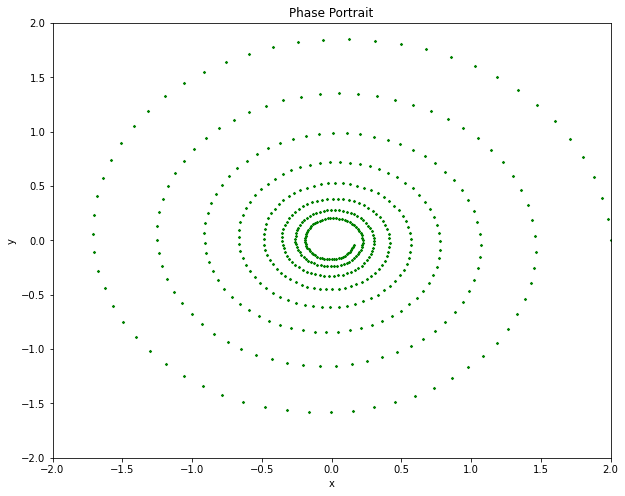

In [1]:
import torch.nn as nn
import torch
from torchdiffeq import odeint_adjoint as odeint
from utils import plot_trajectories, makedirs, get_batch
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

num_points = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_time = 10
batch_size = 20
t_max = 30.

# Set initial value and "A" matrix for true dynamics
true_y0 = torch.tensor([[2., 0.]]).to(device)
normalize = colors.Normalize(vmin=-1, vmax=1)
t = torch.linspace(0., 25., num_points).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)
# Create true ODE
class true_ode(nn.Module):
     def forward(self, t, y):
        return torch.mm(y, true_A)
# Get true trajectory of data points
with torch.no_grad():
    true_y = odeint(true_ode(), true_y0, t, method='dopri5')
# Plot true trajectory
plot_trajectories(true_y)

Now we will create a neuralODE that tries to learn the spiral dynamics shown above.

In [2]:
class ODENet(nn.Module):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        """
        in_dim: dimensions of input
        hid_dim: dimension of hidden dimension
        """
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

    def forward(self, t, z):
        return self.net(z)

Iter 0155 | Total Loss 0.374383


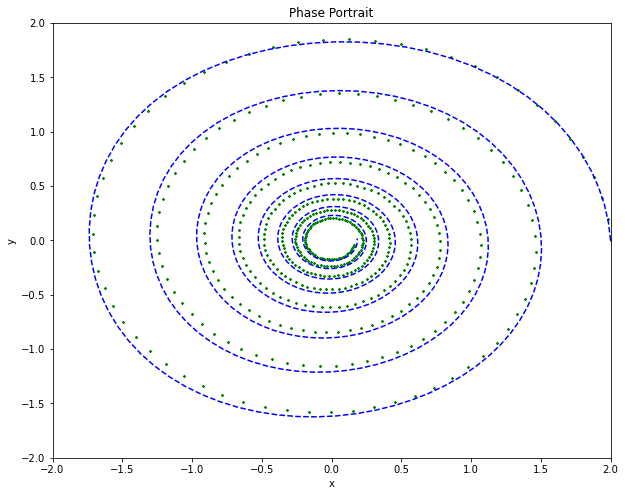

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

num_epochs = 160
func = ODENet(2, 50)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
itr = 0

# Set up phase space plot
makedirs('png')


# Train
for itr in range(num_epochs):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(t, true_y, batch_time, num_points, batch_size, device)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 5 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            
            plot_trajectories(true_y, pred_y, save_path='png/{:03d}'.format(itr))
            itr += 1


## Neural ODE for Image Classification

We will now try to use a Neural ODE for Fashion MNIST dataset. 

## NeuralODE for Latent Time Series Modeling